In [1]:
!pip install segmentation_models_pytorch
!pip install pip install opencv-python


In [2]:
import os
import json
import warnings
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import cv2


warnings.filterwarnings(action='ignore', category=UserWarning)

C:\Users\vudod\anaconda3\envs\nova\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vudod\anaconda3\envs\nova\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vudod\anaconda3\envs\nova\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\vudod\anaconda3\envs\nova\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
device

'cuda'

In [6]:
class CariesDataset(Dataset):
    def __init__(self, images_path_list, labels_path_list, augmentation = True, device = 'cpu', image_size = (384, 768)):
        self.images = images_path_list
        self.labels = labels_path_list
        self.augmentation = augmentation
        self.device = device

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
        
        if self.augmentation:
            self.same_augmentation = transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.RandomHorizontalFlip(p = 0.5)
            ])

            self.different_augmentation = transforms.Compose([
                transforms.RandomAdjustSharpness(2),
                transforms.ColorJitter(brightness=0.5, contrast=0.5)
            ])

        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = Image.open(self.labels[idx])
        
        if self.augmentation:
            seed = np.random.randint(0, 10000)
            
            torch.random.manual_seed(seed)
            image = self.same_augmentation(image)
            image = self.different_augmentation(image)
            
            torch.random.manual_seed(seed)
            label = self.same_augmentation(label)
            
        image = self.transform(image).to(self.device)
        label = self.transform(label).to(self.device)
        
        label = 1. * (label != 0)
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [7]:
image_path = './images_cut/'
labels_path = './labels_cut/'

file_names = [filename for filename in os.listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)


train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]

eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

In [8]:
train_dataset = CariesDataset(
    images_path_list = train_image_path,
    labels_path_list = train_mask_path,
    augmentation = True,
    device = device,
)

eval_dataset = CariesDataset(
    images_path_list = eval_image_path,
    labels_path_list = eval_mask_path,
    augmentation = False,
    device = device,
)

toPIL = transforms.ToPILImage()

batch_size = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=1)

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1, activation = None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.activation = activation

    def forward(self, inputs, targets):
        if self.activation:
            inputs = self.activation(inputs)       

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice
    

    
def metric_calculate(prediction: np.ndarray, target: np.ndarray):

    target = np.uint8(target.flatten() > 0.5)
    prediction = np.uint8(prediction.flatten() > 0.5)
    TP = (prediction * target).sum()
    FN = ((1 - prediction) * target).sum()
    TN = ((1 - prediction) * (1 - target)).sum()
    FP = (prediction * (1 - target)).sum()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-4)
    iou = TP / (TP + FP + FN + 1e-4)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-4)
    pre = TP / (TP + FP + 1e-4)
    spe = TN / (FP + TN + 1e-4)
    sen = TP / (TP + FN + 1e-4)
    
    return acc, iou, dice, pre, spe, sen

In [10]:
model = smp.UnetPlusPlus(
    encoder_name = 'efficientnet-b0',        
    encoder_weights = 'imagenet',     
    in_channels = 1,                  
    classes = 1,
).to(device)

model_name = 'UNetEfficientnetB0'

criterion = DiceLoss(activation=F.sigmoid)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epoch = 50

In [11]:
train_dataloader
    


In [12]:
print (f'Training {model_name} start.')

IoU_max = 0.
losses_train, losses_val = [], []
metrics = []

for epoch in tqdm(range(num_epoch)):
    current_train_loss, current_val_loss = 0., 0.
    current_metric = np.zeros(6)

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in eval_dataloader:
            logits = model(images)
            loss = criterion(logits, labels)

            current_val_loss += loss.item() / len(eval_dataloader)
            current_metric += np.array(metric_calculate(
                logits.cpu().detach().numpy(), 
                labels.cpu().detach().numpy())) / len(eval_dataloader)

    losses_train.append(current_train_loss)
    losses_val.append(current_val_loss)
    metrics.append(current_metric.tolist())

    if IoU_max < metrics[-1][1]:
        torch.save(model, f'{model_name}-best.pth')
        IoU_max = metrics[-1][1]

    print (f'Epoch: {epoch + 1}, train_loss: {losses_train[-1]:.4f}, val_loss: {losses_val[-1]:.4f}, IoU: {metrics[-1][1]:.4f}')


log = {}
log['train_loss'] = losses_train 
log['eval_loss'] = losses_val
log['metric'] = metrics
log['best_score'] = IoU_max

torch.save(model, f'{model_name}-last.pth')

with open(f'log.txt', 'w') as outfile:
    json.dump(log, outfile) 

torch.cuda.empty_cache()

print ('- - ' * 30)
print (f'Training {model_name} done. Best IoU: {IoU_max:.4f}.')
print ('- - ' * 30)

Training UNetEfficientnetB0 start.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.9834, val_loss: 0.9866, IoU: 0.0108
Epoch: 2, train_loss: 0.9717, val_loss: 0.9763, IoU: 0.0989
Epoch: 3, train_loss: 0.9604, val_loss: 0.9557, IoU: 0.1228
Epoch: 4, train_loss: 0.9344, val_loss: 0.9774, IoU: 0.0524
Epoch: 5, train_loss: 0.8882, val_loss: 0.9117, IoU: 0.2188
Epoch: 6, train_loss: 0.8014, val_loss: 0.8892, IoU: 0.2292
Epoch: 7, train_loss: 0.6792, val_loss: 0.9211, IoU: 0.1347
Epoch: 8, train_loss: 0.5729, val_loss: 0.8616, IoU: 0.1666
Epoch: 9, train_loss: 0.4847, val_loss: 0.6856, IoU: 0.2691
Epoch: 10, train_loss: 0.4083, val_loss: 0.5883, IoU: 0.3128
Epoch: 11, train_loss: 0.3712, val_loss: 0.7541, IoU: 0.1829
Epoch: 12, train_loss: 0.3694, val_loss: 0.9242, IoU: 0.0449
Epoch: 13, train_loss: 0.3590, val_loss: 0.4705, IoU: 0.3852
Epoch: 14, train_loss: 0.3117, val_loss: 0.4643, IoU: 0.3938
Epoch: 15, train_loss: 0.3223, val_loss: 0.4361, IoU: 0.4200
Epoch: 16, train_loss: 0.2870, val_loss: 0.4528, IoU: 0.4087
Epoch: 17, train_loss: 0.2895, va

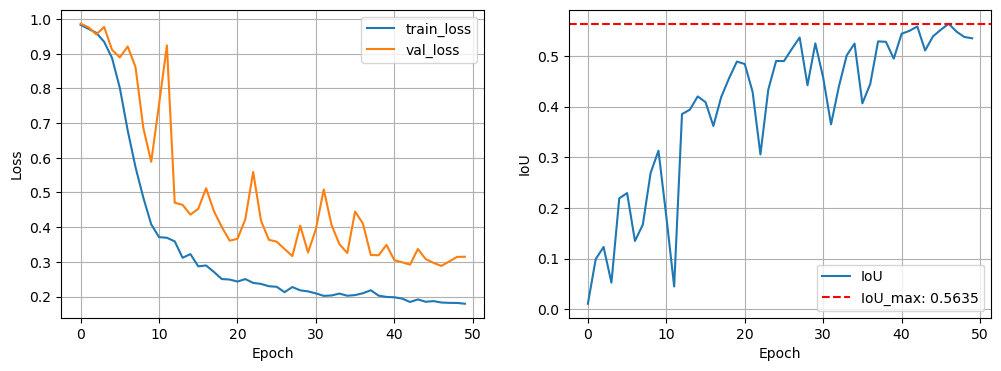

In [13]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([metric[1] for metric in metrics], label = 'IoU')
plt.axhline (IoU_max, linestyle = '--', color = 'red', label = f'IoU_max: {IoU_max:.4f}')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.savefig('efficientnet-b0.png')
plt.show()

In [14]:
model = torch.load('UNetEfficientnetB0-best.pth').eval()
image, label = eval_dataset[6]

In [15]:
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)


In [16]:
probabilities

tensor([[[6.7836e-04, 3.0185e-05, 4.2018e-05,  ..., 2.3724e-05,
          1.7472e-05, 6.1401e-04],
         [5.1852e-05, 8.0228e-07, 1.9948e-06,  ..., 7.4015e-07,
          5.1885e-07, 2.8762e-05],
         [1.2038e-04, 3.6259e-06, 1.0105e-05,  ..., 9.5914e-06,
          4.5289e-06, 1.0551e-04],
         ...,
         [1.4314e-04, 7.5417e-06, 1.2671e-05,  ..., 8.8133e-06,
          3.1934e-06, 7.9465e-05],
         [9.6761e-05, 2.9163e-06, 4.1795e-06,  ..., 4.2417e-06,
          3.2707e-06, 9.0323e-05],
         [1.0318e-03, 6.4678e-05, 8.5340e-05,  ..., 1.0141e-04,
          1.4283e-04, 1.4418e-03]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

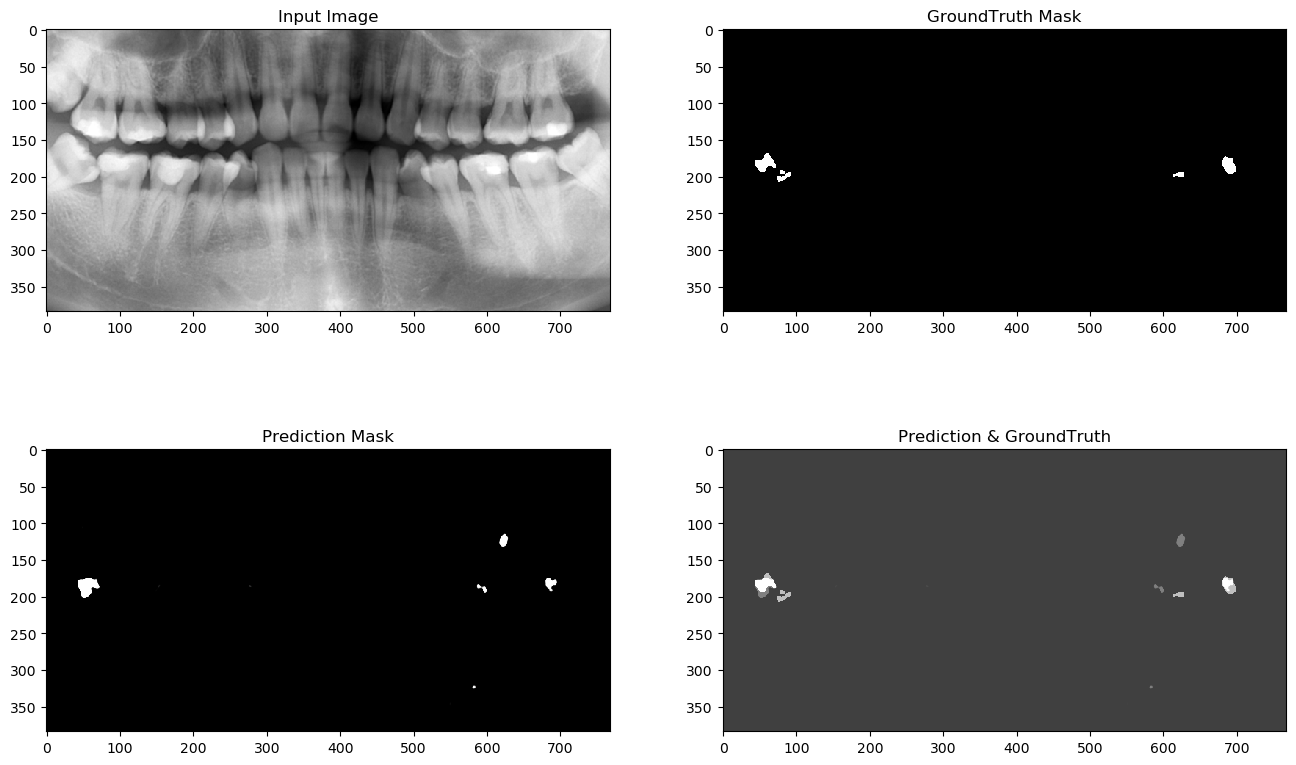

In [17]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 2, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(toPIL(label), cmap='gray')
plt.title('GroundTruth Mask')

plt.subplot(2, 2, 3)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Prediction Mask')

plt.subplot(2, 2, 4)
plt.imshow(toPIL(probabilities), alpha = 0.5, cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('Prediction & GroundTruth')

plt.show()

In [18]:
os.getcwd()

'D:\\NovaInc\\teeth'

In [19]:
anno_paths=[]
for dirname, _, filenames in os.walk('./annotations/bboxes_caries/'):
    for filename in filenames:
        anno_paths+=[(os.path.join(dirname, filename))]
        
anno_paths.sort()

In [20]:
anno_paths

['./annotations/bboxes_caries/1008.txt',
 './annotations/bboxes_caries/1009.txt',
 './annotations/bboxes_caries/1016.txt',
 './annotations/bboxes_caries/1018.txt',
 './annotations/bboxes_caries/1026.txt',
 './annotations/bboxes_caries/1033.txt',
 './annotations/bboxes_caries/1042.txt',
 './annotations/bboxes_caries/1050.txt',
 './annotations/bboxes_caries/1058.txt',
 './annotations/bboxes_caries/1067.txt',
 './annotations/bboxes_caries/1074.txt',
 './annotations/bboxes_caries/1080.txt',
 './annotations/bboxes_caries/1083.txt',
 './annotations/bboxes_caries/1088.txt',
 './annotations/bboxes_caries/1090.txt',
 './annotations/bboxes_caries/1091.txt',
 './annotations/bboxes_caries/1092.txt',
 './annotations/bboxes_caries/1096.txt',
 './annotations/bboxes_caries/306.txt',
 './annotations/bboxes_caries/310.txt',
 './annotations/bboxes_caries/318.txt',
 './annotations/bboxes_caries/323.txt',
 './annotations/bboxes_caries/347.txt',
 './annotations/bboxes_caries/350.txt',
 './annotations/bboxes

In [21]:
anno_paths2=[]
for dirname, _, filenames in os.walk('./annotations/bboxes_teeth/'):
    for filename in filenames:
        anno_paths2+=[(os.path.join(dirname, filename))]
        
anno_paths2.sort()

In [22]:
import pandas as pd

,0,1,2,3
0,434,297,486,364
1,1130,322,1161,355
2,1176,334,1185,342
3,801,366,816,400
4,783,380,791,397


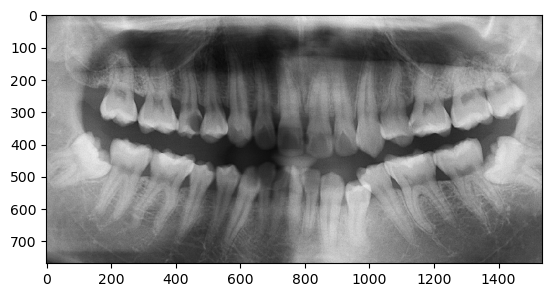

In [24]:
for path in anno_paths[0:1]:
    file=path.split('/')[-1][0:-4]+'.png'
    img_path=os.path.join('./images_cut/',file)
    with open(path, 'r') as file:
        text = file.read().strip().split("\n")
    data = [line.split() for line in text]
    box = pd.DataFrame(data)
    display(box)
    img=plt.imread(img_path)
    
    plt.imshow(img)
    plt.show()

,0,1,2,3
0,697.573181,697.510986,900.908508,861.750488
1,1905.033447,715.254211,2122.338867,966.247070
2,2056.297852,707.747009,2269.509277,874.480896
3,1104.463501,478.137115,1186.843262,717.872803
4,851.793701,712.251892,1029.780029,969.373108
5,1668.369141,789.385620,1841.557129,1039.846313
6,868.844055,435.959656,986.293274,680.141602
7,1749.554443,755.705078,1981.494263,1015.743713
8,1662.300049,441.303528,1751.113281,777.804199
9,1259.090210,427.306244,1341.740356,741.280640


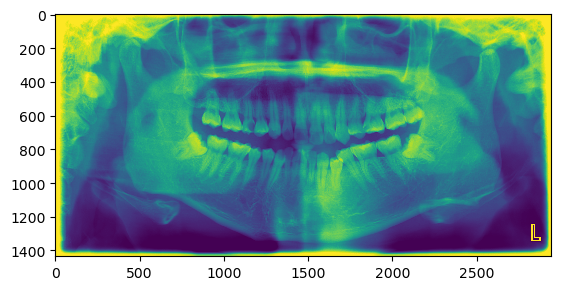

In [25]:
for path in anno_paths2[0:1]:
    file=path.split('/')[-1][0:-4]+'.png'
    img_path=os.path.join('./images/',file)
    with open(path, 'r') as file:
        text = file.read().strip().split("\n")
    data = [line.split() for line in text]
    box = pd.DataFrame(data).astype(float)
    display(box)
    img=plt.imread(img_path)
    
    plt.imshow(img)
    #plt.axis('off')
    plt.show()

In [26]:
def draw_box(anno_path):
    file=anno_path.split('/')[-1][0:-4]+'.png'
    img_path=os.path.join('./images_cut/',file)
    with open(anno_path, 'r') as file:
        text = file.read().strip().split("\n")
    data = [line.split() for line in text]
    box = pd.DataFrame(data)
    box = box.astype(float)
    image = plt.imread(img_path)
    H,W = image.shape[0],image.shape[1]
    #print(H,W)
    for i in range(len(box)):#
        x1=int(box.loc[i,0])
        y1=int(box.loc[i,1])
        x2=int(box.loc[i,2]) 
        y2=int(box.loc[i,3])

        cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2) #green
    
    plt.imshow(image)
    #plt.axis('off')
    plt.show()   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


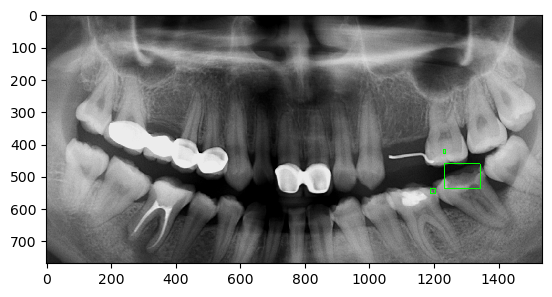

In [27]:
draw_box(anno_paths[8])

In [28]:
def draw_box2(anno_path):
    file=anno_path.split('/')[-1][0:-4]+'.png'
    img_path=os.path.join('./images/',file)
    with open(anno_path, 'r') as file:
        text = file.read().strip().split("\n")
    data = [line.split() for line in text]
    box = pd.DataFrame(data)
    box = box.astype(float)
    image = plt.imread(img_path)
    H,W = image.shape[0],image.shape[1]
    #print(H,W)
    for i in range(len(box)):#
        x1=int(box.loc[i,0])
        y1=int(box.loc[i,1])
        x2=int(box.loc[i,2]) 
        y2=int(box.loc[i,3])

        cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2) #green
    
    plt.imshow(image)
    #plt.axis('off')

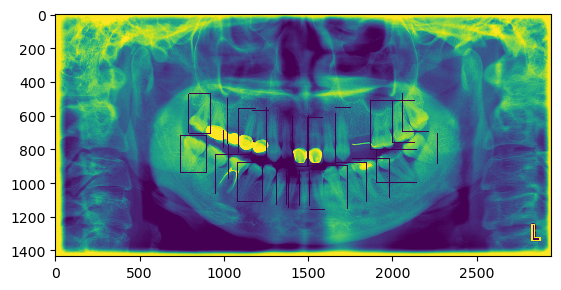

In [29]:
draw_box2(anno_paths2[8])

In [30]:
import random

paths=random.sample(anno_paths,10)
paths2=random.sample(anno_paths2,10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


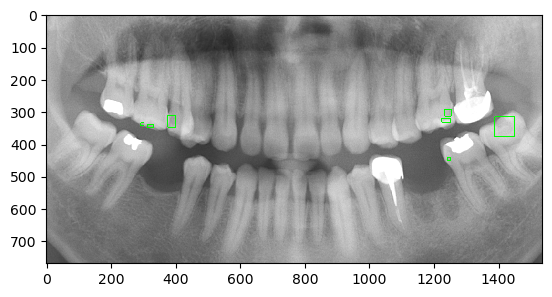

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


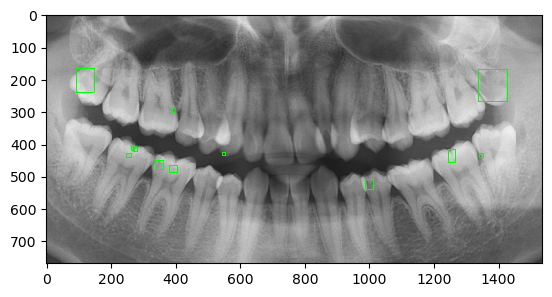

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


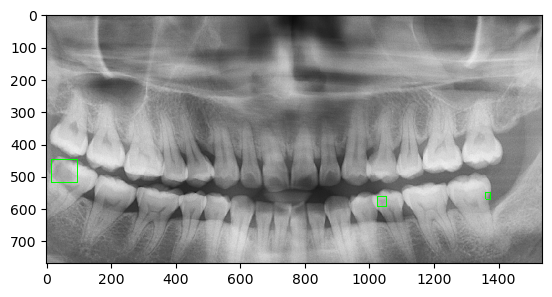

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


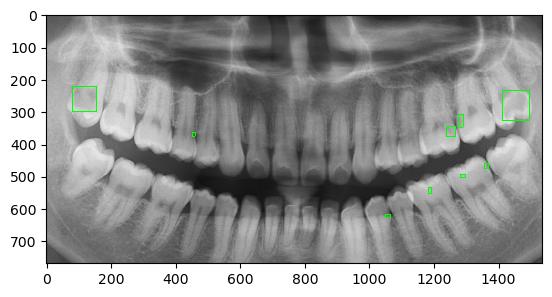

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


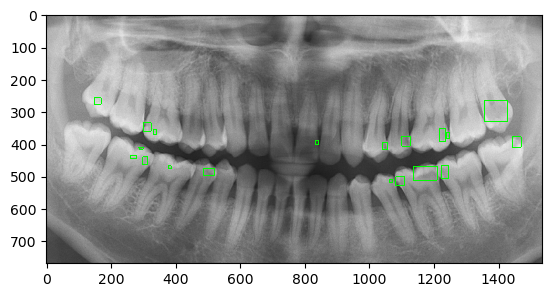

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


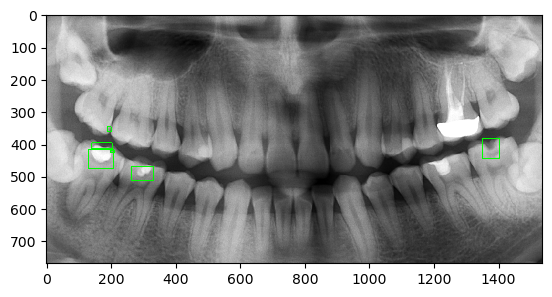

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


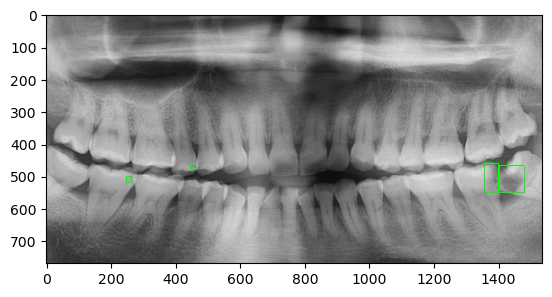

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


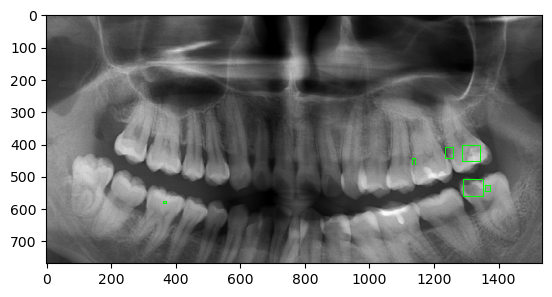

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


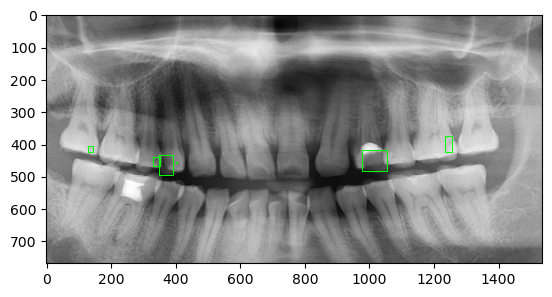

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


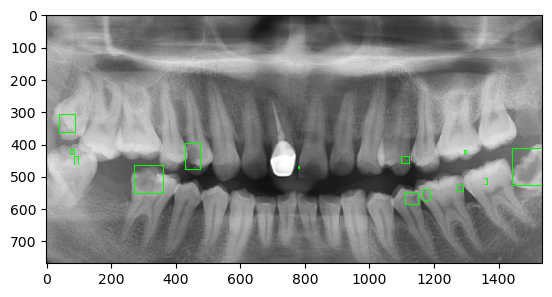

In [31]:
for path in paths:
    draw_box(path)

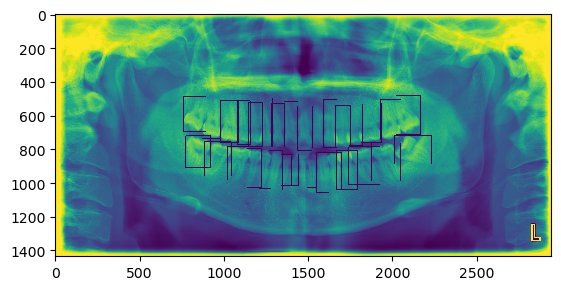

In [32]:
for path in paths2:
    draw_box2(path)